In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit
from tpot import TPOTRegressor
import seaborn as sns
import random
%matplotlib inline

/usr/local/share/jupyteruser/.virtualenvs/jbeipython3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#!/usr/bin/env python -W ignore::DeprecationWarning

Load the data:

In [3]:
reactions = np.loadtxt("../data/fluxes.csv",delimiter=',', skiprows=1,usecols=0,dtype='str')
X = np.transpose(np.loadtxt("../data/transcripts.csv",delimiter=',', skiprows=1,usecols=range(1,53)))
y_full = np.transpose(np.loadtxt("../data/fluxes.csv",delimiter=',', skiprows=1,usecols=range(1,53)))

Accuracy of a regressor is measured in terms of normalized root-mean-square error (NRMSE), with the normalization term used being the average flux. This accuracy term is also known as the coefficient of variation of the RMSD or CV(RMSD).  Lower values of NRMSE indicate less residual variance.

Now loop over all measured metabolic fluxes which are greater than 200.0 umol/gdw/hr and create a random forest regressor for each flux:

Predicted flux for reaction 321 in Strain 3 is 1178.88161083 while measured flux is 1229.088721
done with reaction  321
Predicted flux for reaction 363 in Strain 3 is 409.983417651 while measured flux is 363.4925702
done with reaction  363
Predicted flux for reaction 507 in Strain 3 is 482.499715517 while measured flux is 456.5155193
done with reaction  507
Predicted flux for reaction 778 in Strain 3 is 1152.52783483 while measured flux is 1036.56695
done with reaction  778
Predicted flux for reaction 924 in Strain 3 is 398.04559744 while measured flux is 409.0806316
done with reaction  924
Predicted flux for reaction 992 in Strain 3 is 205.399811513 while measured flux is 211.2145138
done with reaction  992
Predicted flux for reaction 1121 in Strain 3 is 399.379474085 while measured flux is 427.1494264
done with reaction  1121
Predicted flux for reaction 1267 in Strain 3 is 399.379474085 while measured flux is 427.1494264
done with reaction  1267
Predicted flux for reaction 1358 in St

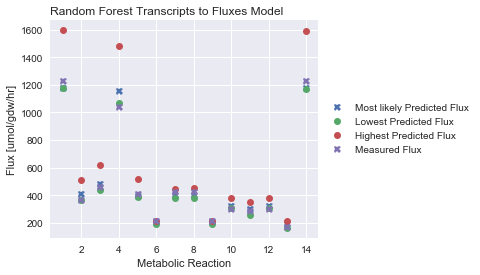

In [4]:
flux_predicted_most_likely = []
flux_predicted_most_lower = []
flux_predicted_most_upper = []
flux_predicted_NRMSE = []
flux_measured =  []

for i in range(2143):
    y = np.copy(y_full[:,i])
    if y.mean()>200.0:
        #use a random foreset regressor with 100 trees, using all 64 cores
        rf = RandomForestRegressor(n_estimators=100, oob_score=False, random_state=0,n_jobs=-1)

        #calculate cross validation using mean squared error in a 1:9 split
        scores = cross_val_score(rf,X,y=y,scoring='neg_mean_squared_error',cv=10)
        y_p = cross_val_predict(rf,X,y=y,cv=10)
        y_err = [ya - yp for ya,yp in zip(y,y_p)]
        
        #calculate normalized root-mean-square error
        NRMSE = np.sqrt(abs(scores.mean()))/y.mean()
        flux_predicted_NRMSE.append(NRMSE)
        
        #specify the training data in a 1:9 split of the 54 samples
        #test data set is the first 5 samples
        #training data set is the last 49 samples
        X_train = X[5:-1,:]
        y_train = y[5:-1]

        #Only look at strain number S. There are 54 total strains or scenarios.
        S = 3
        
        #make the random forest regressor
        rf.fit(X_train,y_train)
        print('Predicted flux for reaction',i,'in Strain',S,'is',rf.predict([X[S,:]])[0], 'while measured flux is',y[S])
        
        #grab the to be fuzzed transcripts for Strain S from X
        fuzzed_transcpits = np.array(X[S,:])

        possible_fluxes=[]
        
        #number of alternative measurements to search over that are 
        #compatible with experimental error
        number_of_measurements = 1000
        
        #assume experimental measurement error is 20%
        experimental_error = 0.20
        
        #first try max and min transcripts possible within experimental error
        fuzzed_transcpits_permuted = (1.0-experimental_error)*np.copy(fuzzed_transcpits)
        possible_fluxes.append(rf.predict(fuzzed_transcpits_permuted.reshape(-1, 7734))[0])
        fuzzed_transcpits_permuted = (1.0+experimental_error)*np.copy(fuzzed_transcpits)
        possible_fluxes.append(rf.predict(fuzzed_transcpits_permuted.reshape(-1, 7734))[0])
        
        #now loop over a large number of possible transcript measurements compatible with experimental error
        for j in range(number_of_measurements):
            fuzzed_transcpits_permuted = np.copy(fuzzed_transcpits)
            for k in range(len(fuzzed_transcpits_permuted)):
                if random.choice([True, False]):
                    fuzzed_transcpits_permuted[k]= fuzzed_transcpits_permuted[k]*(1.0-experimental_error)
                else:
                    fuzzed_transcpits_permuted[k]= fuzzed_transcpits_permuted[k]*(1.0+experimental_error)
            possible_fluxes.append(rf.predict(fuzzed_transcpits_permuted.reshape(-1, 7734))[0])
        possible_fluxes = np.array(possible_fluxes)
        
        flux_predicted_most_lower.append(possible_fluxes.min())
        flux_predicted_most_upper.append(possible_fluxes.max())
        #get predicted flux for Strain S
        flux_predicted_most_likely.append(rf.predict([X[S,:]])[0])
        
        flux_measured.append(y[S])
        
        #plot predictions for flux i
        import seaborn as sns
        plt.scatter(y,y_p)
        plt.scatter(y,y)
        plt.title('Reaction '+str(i))
        plt.xlabel('Measured flux [umol/gdw/hr]')
        plt.ylabel('Predicted flux [umol/gdw/hr]')
        plt.savefig('Reaction'+str(i)+'.pdf')
        plt.close()
        print('done with reaction ',i)

my_range=range(1,len(flux_measured)+1)

fig = plt.figure()
ax = plt.subplot(111)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


import seaborn as sns
ax.plot(my_range, flux_predicted_most_likely,  "X",label='Most likely Predicted Flux')
ax.plot(my_range, flux_predicted_most_lower,  "o",label='Lowest Predicted Flux')
ax.plot(my_range, flux_predicted_most_upper,  "o",label='Highest Predicted Flux')
ax.plot(my_range, flux_measured,  "X",label='Measured Flux')

ax.set_title("Random Forest Transcripts to Fluxes Model", loc='left')
ax.set_xlabel('Metabolic Reaction')
ax.set_ylabel('Flux [umol/gdw/hr]')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.show()
plt.savefig("predicted-fluxes.pdf")

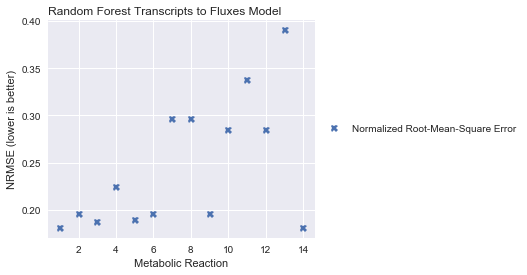

In [5]:
my_range=range(1,len(flux_measured)+1)

fig = plt.figure()
ax = plt.subplot(111)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


import seaborn as sns
ax.plot(my_range, flux_predicted_NRMSE,  "X",label='Normalized Root-Mean-Square Error')

ax.set_title("Random Forest Transcripts to Fluxes Model", loc='left')
ax.set_xlabel('Metabolic Reaction')
ax.set_ylabel('NRMSE (lower is better)')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.show()
plt.savefig("nrmse.pdf")

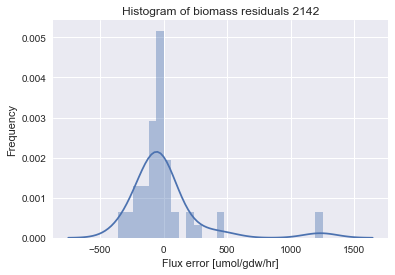

In [6]:
#plot histogram of error for biomass, i.e. the last trained regressor is on biomass
sns.distplot(y_err)
plt.title('Histogram of biomass residuals '+str(i))
plt.xlabel('Flux error [umol/gdw/hr]')
plt.ylabel('Frequency')
plt.savefig('histogram-biomass-residuals.pdf')

TODO: explore sensitivity of fluxes to experimental errors in transcript measurement:

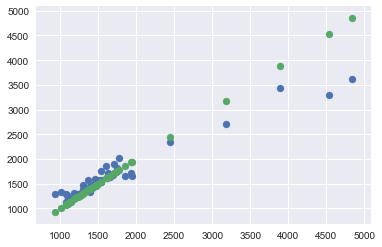

In [7]:
import seaborn as sns
plt.scatter(y,y_p)
plt.scatter(y,y)

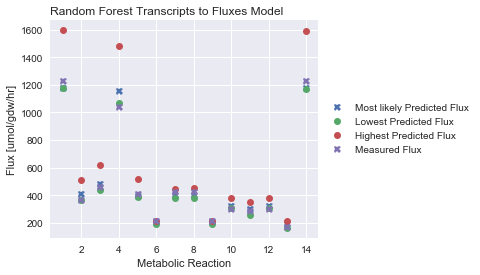

In [11]:
import seaborn as sns
fig = plt.figure()
ax = plt.subplot(111)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.plot(my_range, flux_predicted_most_likely,  "X",label='Most likely Predicted Flux')
ax.plot(my_range, flux_predicted_most_lower,  "o",label='Lowest Predicted Flux')
ax.plot(my_range, flux_predicted_most_upper,  "o",label='Highest Predicted Flux')
ax.plot(my_range, flux_measured,  "X",label='Measured Flux')

ax.set_title("Random Forest Transcripts to Fluxes Model", loc='left')
ax.set_xlabel('Metabolic Reaction')
ax.set_ylabel('Flux [umol/gdw/hr]')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.tight_layout()

#plt.show()
plt.savefig("predicted-fluxes.pdf", bbox_inches='tight')